# Vědecká knihovna SciPy

[SciPy](http://scipy.org/scipylib/index.html) je základní referenční knihovnou, obsahující nástroje pro vědecké výpočty. Najdeme v ní např. speciální funkce, interpolace, Fourierovu transformaci, numerické integrátory a mnohé další. Naším cílem bude ukázat některé z funkcí SciPy.
<!-- TEASER_END -->

Tento notebook byl z (velké) části převzat a přeložen z J.R. Johansson: [Lectures on scientific computing with Python](http://github.com/jrjohansson/scientific-python-lectures) - díky.

## Přehled SciPy

SciPy staví na NumPy a poskytuje mnoho funkcí "vyšší úrovně" pro vědecké výpočty. Ve SciPy je asi dvacet modulů, každý z těchto modulů obsahuje mnoho funkcí a/nebo tříd pro danou oblast.

In [1]:
from IPython.display import IFrame
IFrame('http://docs.scipy.org/doc/scipy/reference/index.html', 900, 450)

## Import SciPy

In [2]:
# toto je typický import scipy
import scipy as sp
# a potřebujeme i numpy a matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Něco na zahřátí -- speciální funkce

Speciální funkce jsou často řešením vědeckých úloh. Jejich implementace je v mnoha případech poměrně náročná. Proto existují knihovny jako je `scipy.special`: http://docs.scipy.org/doc/scipy/reference/special.html#module-scipy.special. 

Podíváme se např. na Besselovy funkce.

In [3]:
import scipy.special

Jednoduché vyčíslení funkcí s daným vstupem.

In [4]:
n = 0    # order
x = 0.0

# Bessel function of first kind
print("J_%d(%f) = %f" % (n, x, sp.special.jn(n, x)))

x = 1.0
# Bessel function of second kind
print("Y_%d(%f) = %f" % (n, x, sp.special.yn(n, x)))

J_0(0.000000) = 1.000000
Y_0(1.000000) = 0.088257


Funkce jsou samozřejmě vektorové, pomocí `matplotlib` si jednoduše nakreslíme graf.

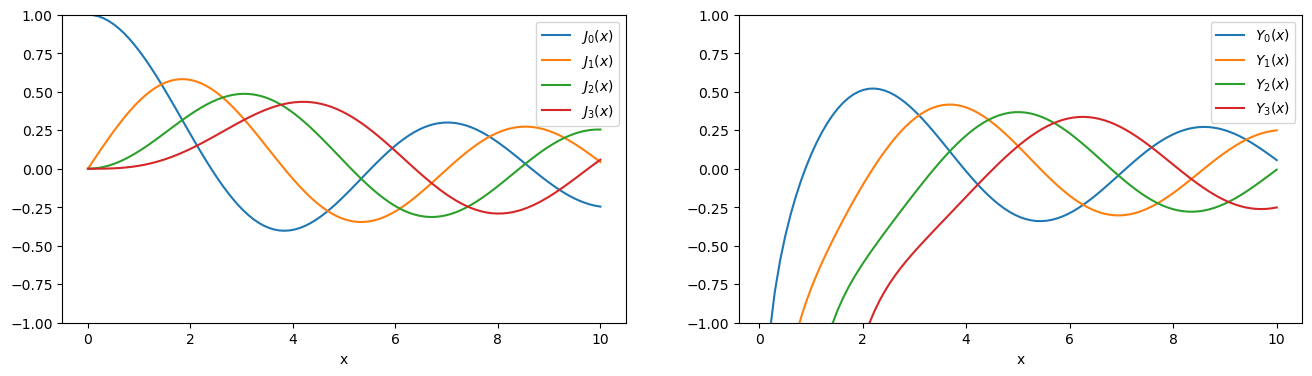

In [5]:
x = np.linspace(0, 10, 100)

fig, ax = plt.subplots(1, 2, figsize=(16,4))
for i, (func, label) in enumerate(zip((sp.special.jn, sp.special.yn), (r"$J_%d(x)$", r"$Y_%d(x)$"))):
    for n in range(4):
        ax[i].plot(x, func(n, x), label=label % n)
    ax[i].legend(loc="best")
    ax[i].set_xlabel("x")
    ax[i].set_ylim(-1, 1)

Zkusíme najít kořeny Besselových funkcí

In [6]:
n = 0  # order
m = 4  # number of roots to compute
sol = sp.special.jn_zeros(n, m)
print('Found roots:', sol)
# zkouška
print('This should be (almost) zero:', sp.special.jn(n, sol))
# využijeme allclose
print('Check using np.allclose:', np.allclose(sp.special.jn(n, sol), 0))

Found roots: [ 2.40482556  5.52007811  8.65372791 11.79153444]
This should be (almost) zero: [ 0.00000000e+00 -1.41172448e-17  1.04035365e-16 -1.77008254e-16]
Check using np.allclose: True


## Numerická integrace

### Vyčíslení určitého integrálu
Numerical evaluation of a function of the type
Často potřebujeme numericky vyčíslit určitý integrál, tj.

$\displaystyle \int_a^b f(x) {\rm d}x$

Numerické integraci se často říká kvadratura, anglicky *quadrature*. Podle toho se jmenují o funkce v modulu `scipy.integrate`, např. `quad`, `dblquad`, `tplquad` nebo obecné `nquad`.

In [7]:
import scipy.integrate

Zkusíme spočítat jednodychý integrál:

$\displaystyle \int_0^1 x {\rm d}x$

In [8]:
val, abserr = sp.integrate.quad(lambda x: x, 0, 1)
print("výsledek = {:g} ± {:.2g}".format(val, abserr))

výsledek = 0.5 ± 5.6e-15


Můžeme dokonce pracovat s nekonečnými mezemi.

In [9]:
val, abserr = sp.integrate.quad(lambda x: np.exp(-x ** 2), -np.inf, np.inf)
print("výsledek = {:g} ± {:.2g}".format(val, abserr))
print("rozdíl od přesné hodnoty (√π) = {:g}".format(val - np.sqrt(np.pi)))

výsledek = 1.77245 ± 1.4e-08
rozdíl od přesné hodnoty (√π) = 0


Vícerozměrná integrace funguje podobně. Rozdíl je ovšem v tom, že vnitřní meze jsou obecně funkce vnějších proměnných. Tady k tomu využijeme anonymní (`lambda`) funkce.

In [10]:
def integrand(x, y):
    return np.exp(-x**2 - y**2)

x_lower = 0  
x_upper = 10
y_lower = 0
y_upper = 10

val, abserr = sp.integrate.dblquad(integrand, x_lower, x_upper, lambda x : y_lower, lambda x: y_upper)

print(val, abserr)

0.7853981633974476 1.3753098510206357e-08


In [11]:
# spočítáme obsah kruhu s daným poloměrem
r = 1 / np.sqrt(np.pi)

def integrand(x, y):
    return 1

def y_upper(x):
    return np.sqrt(r**2 - x**2)

def y_lower(x):
    return -np.sqrt(r**2 - x**2)

val, abserr = sp.integrate.dblquad(integrand, -r, r, y_lower, y_upper)

print("výsledek = {:g} ± {:.2g}".format(val, abserr))
assert np.allclose(val, np.pi * r**2)

výsledek = 1 ± 6.4e-10


### Obyčejné diferenciální rovnice (ODR)

`scipy.integrate` (ano, řešení ODR je v tomto modulu, protože řešením ODR je určitý integrál) obsahuje `odeint`, které je jednodušší, a objektové rozhraní `ode`, které umožňuje větší kontrolu.

My teď použijeme `odeint` pro řešení rovnic dvojitého kyvadla.

ODR (nebo jejich soustava) je často zadaná jako

$y' = f(y, t)$

s počátečními podmínkami

$y(t=0) = y_0$

`odeint` pak lze použít jednoduše:

    y_t = odeint(f, y_0, t)

kde `t` je předem zadané pole, ve kterých požadujeme řešení.

#### Příklad 1: jednoduché kyvadlo

Rovnice jednoduchého gravitačního kyvadla (pro malou amplitudu) je

$\displaystyle {\ddot \theta} + \frac{g}{L}\theta = 0$

Řešení je jednoduché:

$\displaystyle {\theta} = \theta_0 \cos\left( \sqrt{\frac{g}{L}} t \right) $

Zkusme si tuto rovnici vyřešit numericky. Jelikož potřebujeme rovnice prvního řádu, definujeme vektor $x = \left(\theta , \dot\theta \right)$, takže

$\displaystyle {\dot x_1} = x_2$

$\displaystyle {\dot x_2} = - \frac{g}{L}\theta $


In [12]:
import scipy.constants

L = 0.5
m = 0.1

def dx_pendulum(x, t):
    """
    The right-hand side of the pendulum ODE
    """
    theta, dtheta = x[0], x[1]
    
    d_theta_dt = dtheta
    d_dtheta_dt = - sp.constants.g / L * theta
    
    return d_theta_dt, d_dtheta_dt

In [13]:
# počáteční stav
x0 = [np.pi / 8, 0]
# časy pro řešení
t = np.linspace(0, 10, 250)
# a konečně řešení
x = sp.integrate.odeint(dx_pendulum, x0, t)

In [14]:
# analytické řešení
x_anal = x0[0] * np.cos(np.sqrt(sp.constants.g / L) * t)

Text(0.5, 0, 't')

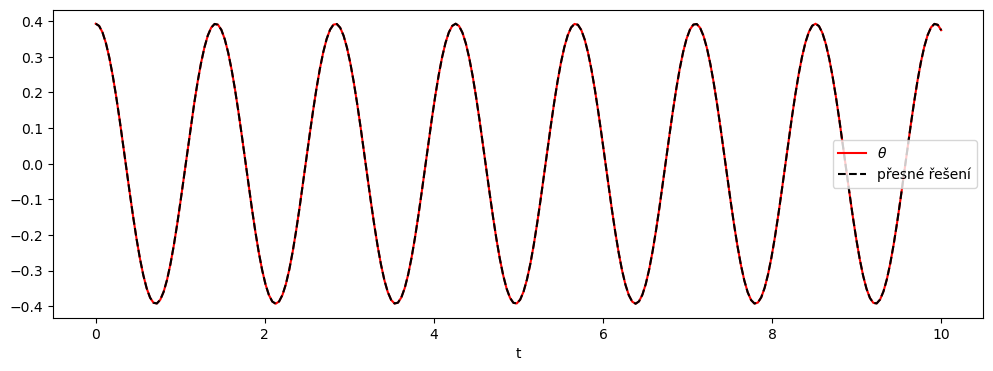

In [15]:
fig, axes = plt.subplots(figsize=(12, 4))
axes.plot(t, x[:, 0], 'r', label=r"$\theta$")
# axes.plot(t, x[:, 1], 'b', label=r"$d\theta / dt$")
axes.plot(t, x_anal, 'k--', label=u"přesné řešení")
axes.legend(loc="best")
axes.set_xlabel("t")

Podívejme se na frekvenční spektrum pomocí FFT.

In [16]:
import scipy.fftpack as fftpack

In [17]:
F = fftpack.fft(x[:,0])

In [18]:
# takto získáme frekvence
w = fftpack.fftfreq(F.shape[0], t[1] - t[0])
w_mask = w >= 0

Text(0.5, 1.0, 'Fourier spectrum amplitude')

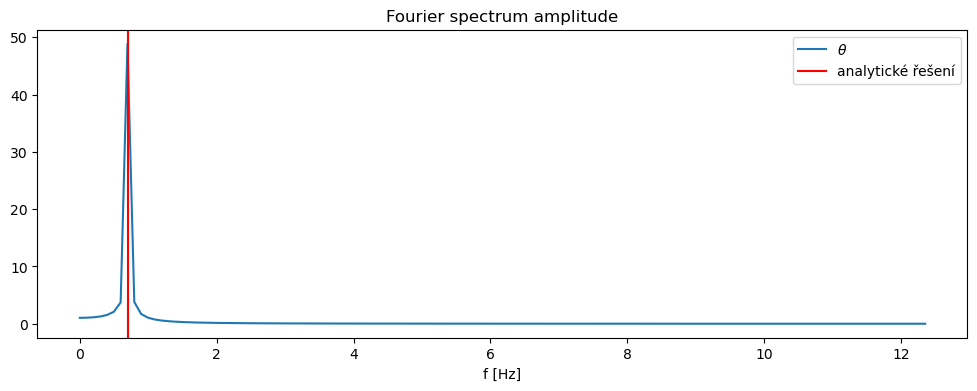

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(w[w_mask], np.abs(F[w_mask]), label=r"$\theta$")
ax.axvline(np.sqrt(sp.constants.g / L) / (2 * np.pi), color='r', label="analytické řešení")
ax.legend(loc="best")
ax.set_xlabel("f [Hz]")
ax.set_title("Fourier spectrum amplitude")

Text(0.5, 1.0, 'Fourier spectrum angle')

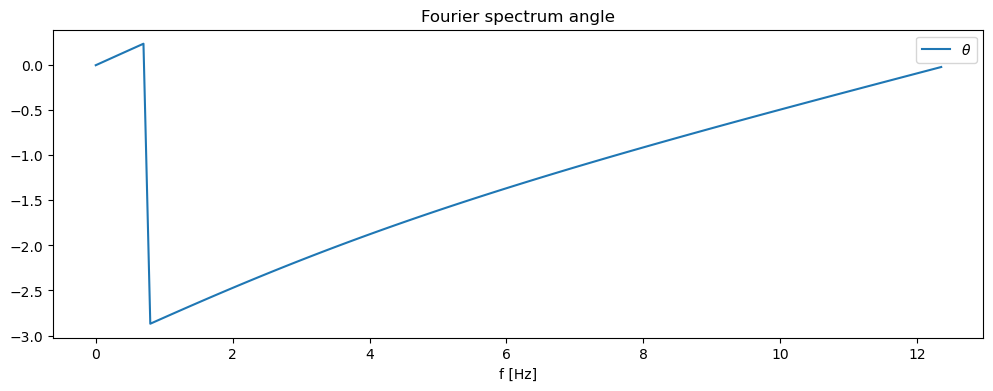

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(w[w_mask], np.angle(F[w_mask]), label=r"$\theta$")
# ax.axvline(sqrt(g/L)/(2*pi), color='r', label=u"analytické řeěení")
ax.legend(loc="best")
ax.set_xlabel("f [Hz]")
ax.set_title("Fourier spectrum angle")

#### Příklad 2: dvojité kyvadlo

Popis dvojitého kyvadla najdeme např. na Wikipedii: http://en.wikipedia.org/wiki/Double_pendulum

In [21]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/c/c9/Double-compound-pendulum-dimensioned.svg')

Pohybové rovnice jso:

${\dot \theta_1} = \frac{6}{m\ell^2} \frac{ 2 p_{\theta_1} - 3 \cos(\theta_1-\theta_2) p_{\theta_2}}{16 - 9 \cos^2(\theta_1-\theta_2)}$

${\dot \theta_2} = \frac{6}{m\ell^2} \frac{ 8 p_{\theta_2} - 3 \cos(\theta_1-\theta_2) p_{\theta_1}}{16 - 9 \cos^2(\theta_1-\theta_2)}.$

${\dot p_{\theta_1}} = -\frac{1}{2} m \ell^2 \left [ {\dot \theta_1} {\dot \theta_2} \sin (\theta_1-\theta_2) + 3 \frac{g}{\ell} \sin \theta_1 \right ]$

${\dot p_{\theta_2}} = -\frac{1}{2} m \ell^2 \left [ -{\dot \theta_1} {\dot \theta_2} \sin (\theta_1-\theta_2) +  \frac{g}{\ell} \sin \theta_2 \right]$

Aby jsme si zjednodušili programování, použijeme notaci $x = [\theta_1, \theta_2, p_{\theta_1}, p_{\theta_2}]$, takže

${\dot x_1} = \frac{6}{m\ell^2} \frac{ 2 x_3 - 3 \cos(x_1-x_2) x_4}{16 - 9 \cos^2(x_1-x_2)}$

${\dot x_2} = \frac{6}{m\ell^2} \frac{ 8 x_4 - 3 \cos(x_1-x_2) x_3}{16 - 9 \cos^2(x_1-x_2)}$

${\dot x_3} = -\frac{1}{2} m \ell^2 \left [ {\dot x_1} {\dot x_2} \sin (x_1-x_2) + 3 \frac{g}{\ell} \sin x_1 \right ]$

${\dot x_4} = -\frac{1}{2} m \ell^2 \left [ -{\dot x_1} {\dot x_2} \sin (x_1-x_2) +  \frac{g}{\ell} \sin x_2 \right]$

In [22]:
L = 0.5
m = 0.1

def dx(x, t):
    """
    The right-hand side of the pendulum ODE
    """
    x1, x2, x3, x4 = x[0], x[1], x[2], x[3]
    
    dx1 = 6.0/(m*L**2) * (2 * x3 - 3 * np.cos(x1-x2) * x4)/(16 - 9 * np.cos(x1-x2)**2)
    dx2 = 6.0/(m*L**2) * (8 * x4 - 3 * np.cos(x1-x2) * x3)/(16 - 9 * np.cos(x1-x2)**2)
    dx3 = -0.5 * m * L**2 * ( dx1 * dx2 * np.sin(x1-x2) + 3 * (sp.constants.g/L) * np.sin(x1))
    dx4 = -0.5 * m * L**2 * (-dx1 * dx2 * np.sin(x1-x2) + (sp.constants.g/L) * np.sin(x2))
    
    return [dx1, dx2, dx3, dx4]

In [23]:
# počáteční stav
x0 = [np.pi/4, np.pi/2, 0, 0]

In [24]:
# časy pro řešení
t = np.linspace(0, 10, 250)

In [25]:
# a konečně řešení
x = sp.integrate.odeint(dx, x0, t)

Nyní použijeme naší znalosti `matplotlib` a řešení si nakreslíme.

Text(0, 0.5, 'y')

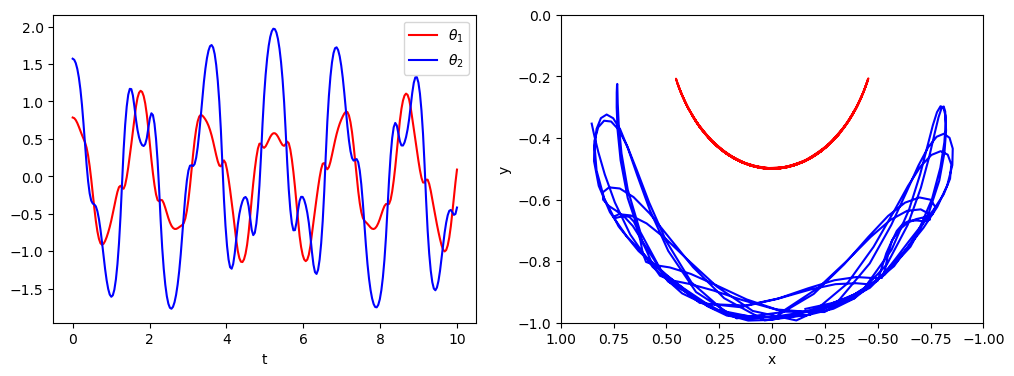

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(t, x[:, 0], 'r', label=r"$\theta_1$")
axes[0].plot(t, x[:, 1], 'b', label=r"$\theta_2$")
axes[0].legend(loc="best")
axes[0].set_xlabel("t")
# teď převedeme úhly na x, y souřadnice
x1 = + L * np.sin(x[:, 0])
y1 = - L * np.cos(x[:, 0])
x2 = x1 + L * np.sin(x[:, 1])
y2 = y1 - L * np.cos(x[:, 1])
# a opět nakreslíme    
axes[1].plot(x1, y1, 'r', label="pendulum1")
axes[1].plot(x2, y2, 'b', label="pendulum2")
axes[1].set_ylim([-1, 0])
axes[1].set_xlim([1, -1])
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

#### Fourierova transformace pomocí `fftpack`

In [27]:
import scipy.fftpack as fftpack

In [28]:
F = fftpack.fft(x[:,0])
F = np.hstack((F[:,np.newaxis], fftpack.fft(x[:,1])[:,np.newaxis]))

In [29]:
# takto získáme frekvence
w = fftpack.fftfreq(F.shape[0], t[1] - t[0])
w_mask = w >= 0

Text(0.5, 1.0, 'Fourier spectrum amplitude')

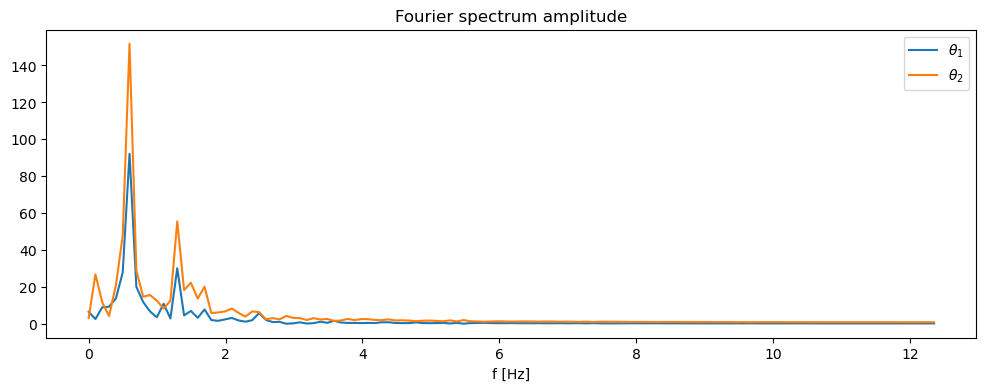

In [30]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(w[w_mask], abs(F[w_mask,0]), label=r"$\theta_1$")
ax.plot(w[w_mask], abs(F[w_mask,1]), label=r"$\theta_2$")
ax.legend(loc="best")
ax.set_xlabel("f [Hz]")
ax.set_title("Fourier spectrum amplitude")

Text(0.5, 1.0, 'Fourier spectrum argument')

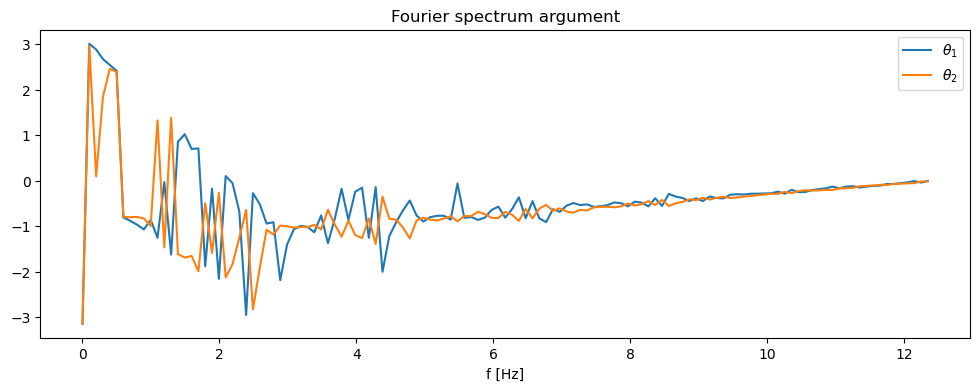

In [31]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(w[w_mask], np.angle(F[w_mask,0]), label=r"$\theta_1$")
ax.plot(w[w_mask], np.angle(F[w_mask,1]), label=r"$\theta_2$")
ax.legend(loc="best")
ax.set_xlabel("f [Hz]")
ax.set_title("Fourier spectrum argument")

## Lineární algebra

Modul `scipy.linalg` obsahuje velké množství nástrojů pro lineární algebru -- pro řešení lineárních rovnic, hledání vlastních čísel, různé dekompozice aj. Obsahuje také všechny funkce z `numpy.linalg`. Více informací viz http://docs.scipy.org/doc/scipy/reference/linalg.html.

In [32]:
import scipy.linalg

### Řešení soustavy lineárních rovnic


In [33]:
n_eq = 3
A = np.random.rand(n_eq, n_eq)
b = np.random.rand(n_eq)

Použijeme funkci `solve` na řešení soustavy.

In [34]:
x = sp.linalg.solve(A, b)

Stejné řešení pravděpodobně dostaneme pomocí inverzní matice.

In [35]:
xx = np.linalg.inv(A).dot(b)

Co a kdy bude rychlejší?

In [36]:
%%timeit
sp.linalg.solve(A, b)

8.73 μs ± 28.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [37]:
%%timeit
sp.linalg.inv(A).dot(b)

5.04 μs ± 52.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Ještě zkontrolujeme řešení.

In [38]:
print("chyba solve = {}".format(np.linalg.norm(A.dot(x) - b)))
print("chyba inv   = {}".format(np.linalg.norm(A.dot(xx) - b)))

chyba solve = 7.791361360319881e-16
chyba inv   = 3.2053784592957234e-15


### Vlastní čísla

Vlastní čísla matice $A$ splňují rovnici $\displaystyle A v_n = \lambda_n v_n$, kde $v_n$ je $n$-tý vlastní vektor a $\lambda_n$ je $n$-té vlastní číslo.

`eigvals` najde vlastní čísla, `eig` zároveň i vlstní vektory.

In [39]:
sp.linalg.eigvals(A)

array([ 1.3830469 +0.j, -0.03528554+0.j,  0.54065715+0.j])

In [40]:
evals, evecs = sp.linalg.eig(A)

Vlastní vektory jsou ve sloupcích a v odpovídajícím pořadí k vlastním číslům. Můžeme si to jednoduše ověřit.

In [41]:
for n in range(len(evals)):
    print(np.linalg.norm(A.dot(evecs[:,n]) - evals[n] * evecs[:,n]))

4.47545209131181e-16
3.3216670657159767e-16
6.834017936133213e-17


## Řídké matice

Ŕídké matice osahují jen málé procento nenulových prvků, proto se vyplatí s nimi zacházet speciálním způsobem, včetně uložení v paměti. I s tímto nám SciPy může výrazně pomoci.

In [42]:
import scipy.sparse
import scipy.sparse.linalg

Řídkou matici můžeme vytvořit např. pomocí standardního array obejktu.

In [43]:
# řídká matice uložená běžným způsobem
M = np.array([[1,0,0,0], [0,3,0,0], [0,1,1,0], [1,0,0,1]])
print(M)

[[1 0 0 0]
 [0 3 0 0]
 [0 1 1 0]
 [1 0 0 1]]


In [44]:
# vytvoříme řídkou matici ve formátu CSR (compressed sparse row)
A = sp.sparse.csr_matrix(M)
print(A)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	1
  (1, 1)	3
  (2, 1)	1
  (2, 2)	1
  (3, 0)	1
  (3, 3)	1


Efektivnější způsob, jak vyvořit řídkou matici, je vytvožit prázdnou a poté přidávat hodnoty pomocí indexů. Použijeme na to LIL (list of list) formát.

In [45]:
A = sp.sparse.lil_matrix((4,4))
A[0,0] = np.random.rand()
A[1,1] = np.random.rand()
A[1,2] = np.random.rand()
A[2,1] = np.random.rand()
A[2,2] = np.random.rand()
A[3,3] = np.random.rand()
print(A)

<List of Lists sparse matrix of dtype 'float64'
	with 6 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	0.037233301637553784
  (1, 1)	0.5367246128658247
  (1, 2)	0.3455197597354325
  (2, 1)	0.13455013165727092
  (2, 2)	0.27712217699244457
  (3, 3)	0.8700405249733052


Takto vytvořenou matici převedeme do CSR formátu, který je obvykle efektivnější, a zkusíme vyřešit lineární systém pomocí konjugovaných gradientů (což nemusí vždy fungovat).

In [46]:
A = sp.sparse.csr_matrix(A)
b = np.random.rand(A.shape[1])
x, info = sp.sparse.linalg.cgs(A, b)

In [47]:
if info == 0:
    print("converged solution, error {:.2g}".format(np.linalg.norm(A * x - b)))
    print(x)
else:
    print("not converged, info = {}".format(info))

converged solution, error 1.3e-14
[23.06803775  1.74106946  0.15624556  0.21287263]


## Interpolace a aproximace

Scipy nabízí jednoduché možnosti pro interpolaci a aproximaci dat.

In [48]:
import scipy.interpolate

### Příklad interpolace
Vyrobíme si nějaká zašuměná data pomocí známé funkce (např. sin) a zkusíme je interpolovat pomocí `interp1d`.

In [49]:
def f(x):
    return np.sin(x)

In [50]:
n = np.arange(0, 10)  
x = np.linspace(0, 9, 100)

y_meas = f(n) + 0.1 * np.random.randn(len(n))  # simulate measurement with noise
y_real = f(x)

linear_interpolation = sp.interpolate.interp1d(n, y_meas)
y_interp1 = linear_interpolation(x)

cubic_interpolation = sp.interpolate.interp1d(n, y_meas, kind='cubic')
y_interp2 = cubic_interpolation(x)

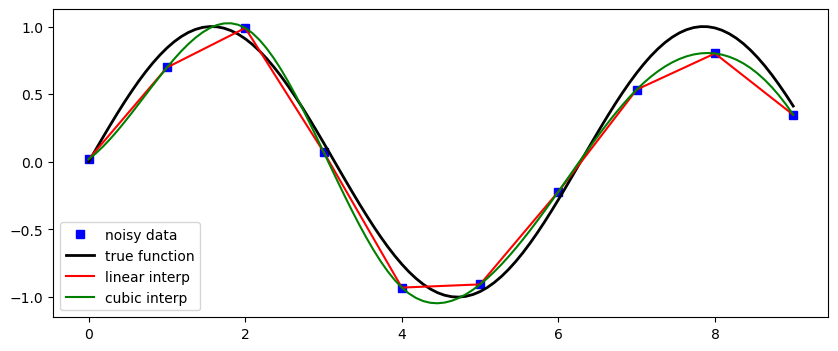

In [51]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(n, y_meas, 'bs', label='noisy data')
ax.plot(x, y_real, 'k', lw=2, label='true function')
ax.plot(x, y_interp1, 'r', label='linear interp')
ax.plot(x, y_interp2, 'g', label='cubic interp')
ax.legend(loc=3);

### Aproximace pomocí splajnů
Nyní se podívejme na splajny, které *aproximují* data, tj. nemusí procházet zadanými body.

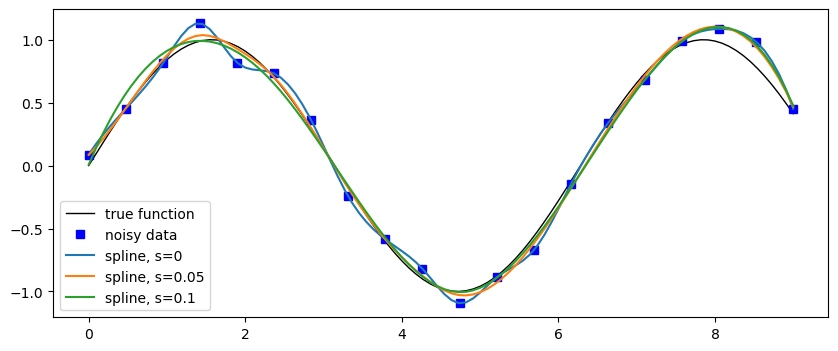

In [52]:
x = np.linspace(0, 9, 100)
n = np.linspace(x[0], x[-1], 20)
y_meas = f(n) + 0.1 * np.random.randn(len(n))  # simulate measurement with noise
y_real = f(x)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x, y_real, 'k', lw=1, label='true function')
ax.plot(n, y_meas, 'bs', label='noisy data')
for s in (0, 0.05, 0.1):
    spline_interpolation = sp.interpolate.UnivariateSpline(n, y_meas, k=3, s=s)
    y_spline = spline_interpolation(x)

    ax.plot(x, y_spline, label='spline, s={}'.format(s))
ax.legend(loc=3)

### Fit pomocí nejmenších čtverců
Tohle je trochu jiná úloha než interpolace nebo aproximace. Nyní máme předem danou funkci s neznámými parametry, o které předpokládáme, že popisuje naše data.

In [53]:
# fitování patří do optimalizace
import scipy.optimize

In [54]:
# předpokládáná funkce, a,b,c jsou neznámé parametry
def f_fit(x, a, b, c):
    return a*np.sin(b*x + c)

In [55]:
x = np.linspace(0, 9, 100)
n = np.linspace(x[0], x[-1], 20)
y_meas = np.sin(n) + 0.1 * np.random.randn(len(n))  # simulate measurement with noise
y_real = np.sin(x)

In [56]:
# počáteční odhad parametrů
guess = [1.3, 0.7, 1]
params, params_covariance = sp.optimize.curve_fit(f_fit, n, y_meas, guess)
print('výsledek: {:.3g} * sin({:.3g} * x {:+.3g})'.format(*params))

výsledek: 1.03 * sin(0.988 * x +0.0646)


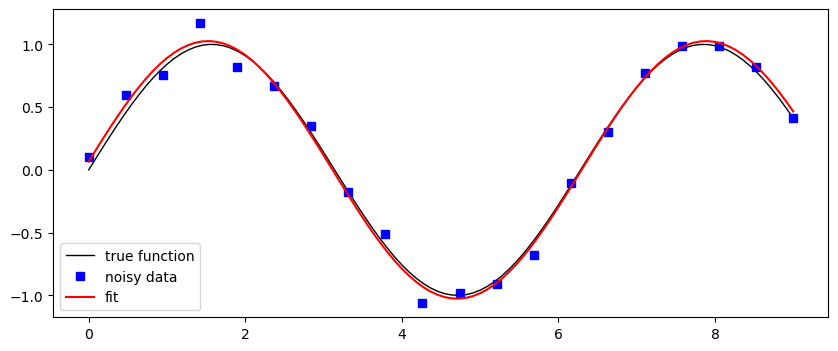

In [57]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x, y_real, 'k', lw=1, label='true function')
ax.plot(n, y_meas, 'bs', label='noisy data')
ax.plot(x, f_fit(x, *params), 'r', label='fit')
ax.legend(loc=3)

## Zpracovnání obrazu

In [58]:
from scipy import ndimage, misc

In [59]:
sample = misc.ascent()

samples = [sample]
titles = ["original"]

samples.append(ndimage.shift(sample, (50, 50)))
titles.append("shift")

samples.append(ndimage.shift(sample, (50, 50), mode='nearest'))
titles.append("shift nearest")

samples.append(ndimage.rotate(sample, 30))
titles.append("rotate")

samples.append(sample[50:-50, 50:-50])
titles.append("crop")

/var/folders/dm/gbbql3p121z0tr22r2z98vy00000gn/T/ipykernel_90914/4101079354.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  sample = misc.ascent()


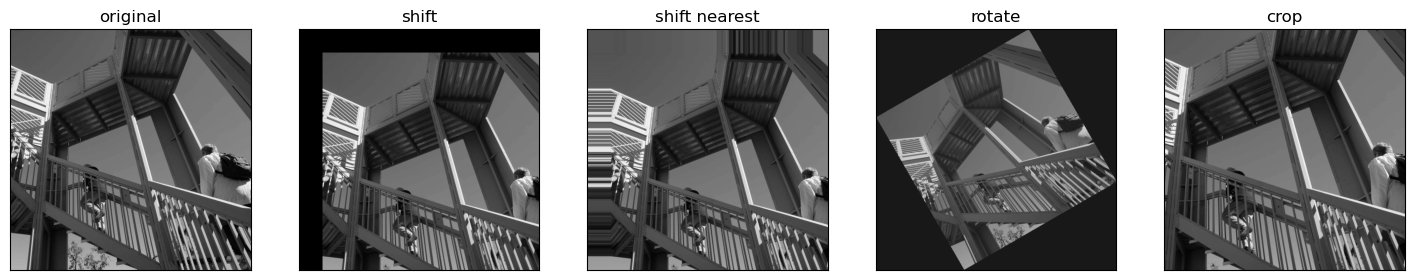

In [60]:
fig, axes = plt.subplots(1, len(samples), figsize=(18,6))
for ax, im, tit in zip(axes, samples, titles):
    ax.imshow(im, cmap=plt.cm.gray)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(tit)

In [62]:
from scipy import signal

noisy_sample = sample.copy().astype(np.float64)
noisy_sample += sample.std() * 1 * np.random.standard_normal(sample.shape)

samples = [noisy_sample]
titles = ["noisy"]

samples.append(ndimage.gaussian_filter(noisy_sample, sigma=3))
titles.append("gaussian filter")

samples.append(ndimage.median_filter(noisy_sample, size=5))
titles.append("median filter")

samples.append(signal.wiener(noisy_sample, (5,5)))
titles.append("wiener filter")

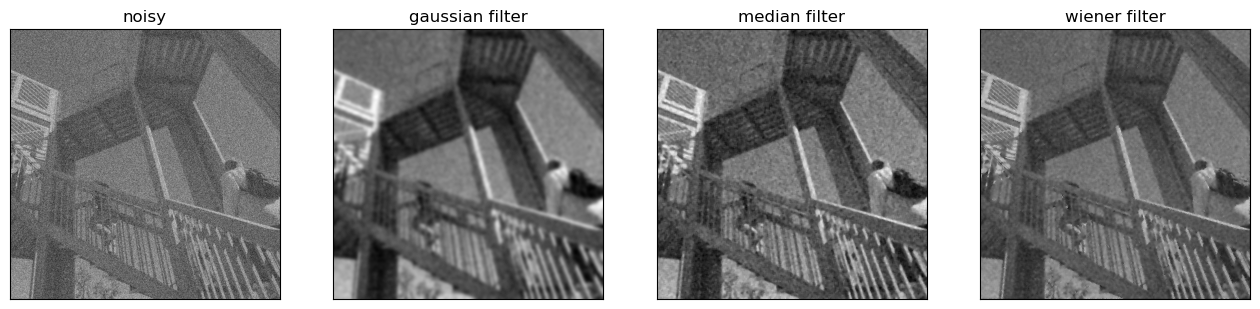

In [63]:
fig, axes = plt.subplots(1, len(samples), figsize=(16,5))
for ax, im, tit in zip(axes, samples, titles):
    ax.imshow(im, cmap=plt.cm.gray)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(tit)